In [2]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy.signal import savgol_filter
from scipy import stats  # New import for mode calculation
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Load in Data
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports'
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../../data/bishkek_csr/03_train_ready/nasal_files'

# --- NEW: Refined Class Strategy ---
# We group clinically similar events and rare events together.
# Label 0 is reserved for 'Normal'.

EVENT_GROUP_TO_LABEL = {
    1: ['Obstructive Apnea'],
    2: ['Hypopnea', 'Central Hypopnea', 'Obstructive Hypopnea'],
    3: ['Central Apnea', 'Mixed Apnea'],
    4: ['RERA'],
    5: ['Desaturation']
}

# --- NEW: Create a mapping from the new groups to readable names ---
LABEL_TO_EVENT_GROUP_NAME = {
    0: 'Normal',
    1: 'Obstructive Apnea',
    2: 'Hypopnea Events',
    3: 'Central/Mixed Apnea',
    4: 'RERA',
    5: 'Desaturation'
}

all_sessions_df_list = []
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))

if not event_files:
    raise FileNotFoundError(f"No event files found in '{EVENTS_FOLDER}'.")

print(f"Found {len(event_files)} event files. Processing each one...")

for event_file_path in event_files:
    # --- 1. Setup paths and IDs ---
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    nasal_file_path = os.path.join(NASAL_FOLDER, f'{session_id}_nasal.csv')

    if not all(os.path.exists(p) for p in [respeck_file_path, nasal_file_path]):
        print(f"  - WARNING: Skipping session '{session_id}'. A corresponding file is missing.")
        continue
    print(f"  - Processing session: {session_id}")
    
    # --- 2. Load CORE data sources ---
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_nasal = pd.read_csv(nasal_file_path)
    df_respeck = pd.read_csv(respeck_file_path)

    # --- 3. Standardize timestamp columns and types ---
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_nasal.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True, errors='ignore')
    df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)

    for df_ in [df_events, df_nasal, df_respeck]:
        df_['timestamp_unix'] = pd.to_numeric(df_['timestamp_unix'], errors='coerce')
        df_.dropna(subset=['timestamp_unix'], inplace=True)
        df_['timestamp_unix'] = df_['timestamp_unix'].astype('int64')

    # --- 4. Calculate the true overlapping time range ---
    start_time = max(df_nasal['timestamp_unix'].min(), df_respeck['timestamp_unix'].min())
    end_time = min(df_nasal['timestamp_unix'].max(), df_respeck['timestamp_unix'].max())
    
    # --- 5. Trim Respeck data to the overlapping time range ---
    df_respeck = df_respeck[(df_respeck['timestamp_unix'] >= start_time) & (df_respeck['timestamp_unix'] <= end_time)].copy()

    if df_respeck.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No Respeck data in the overlapping range.")
        continue

    # --- 6. MODIFIED: Precise Interval-Based Labeling using the NEW GROUPS ---
    print(f"  - Applying precise interval-based labels...")
    df_respeck['Label'] = 0 # Default label is 0 (Normal)
    df_events['Duration_ms'] = (df_events['Duration'] * 1000).astype('int64')
    df_events['end_time_unix'] = df_events['timestamp_unix'] + df_events['Duration_ms']
    
    # Iterate through each defined event group to assign labels
    for label_id, event_names_in_group in EVENT_GROUP_TO_LABEL.items():
        # Filter the events dataframe to include only the events for the current group
        df_filtered_events = df_events[df_events['Event'].isin(event_names_in_group)]
        
        for _, event in df_filtered_events.iterrows():
            start_event = event['timestamp_unix']
            end_event = event['end_time_unix']
            df_respeck.loc[df_respeck['timestamp_unix'].between(start_event, end_event), 'Label'] = label_id

    # --- 7. Finalize session data ---
    df_respeck['SessionID'] = session_id
    all_sessions_df_list.append(df_respeck)

# --- Combine all nights and perform final processing ---
if not all_sessions_df_list:
    raise ValueError("Processing failed. No data was loaded.")

df = pd.concat(all_sessions_df_list, ignore_index=True)

print("\n----------------------------------------------------")
print("Data loading with PURE signals complete.")
print(f"Final DataFrame shape: {df.shape}")
print(f"Final class distribution in raw data: \n{df['Label'].value_counts(normalize=True)}")

Found 9 event files. Processing each one...
  - Processing session: 26-04-2025
  - Applying precise interval-based labels...
  - Processing session: 08-05-2025
  - Applying precise interval-based labels...
  - Processing session: 05-04-2025
  - Applying precise interval-based labels...
  - Processing session: 10-05-2025
  - Applying precise interval-based labels...
  - Processing session: 24-04-2025
  - Applying precise interval-based labels...
  - Processing session: 25-04-2025
  - Applying precise interval-based labels...
  - Processing session: 16-04-2025
  - Applying precise interval-based labels...
  - Processing session: 11-05-2025
  - Applying precise interval-based labels...
  - Processing session: 04-04-2025
  - Applying precise interval-based labels...

----------------------------------------------------
Data loading with PURE signals complete.
Final DataFrame shape: (2363398, 14)
Final class distribution in raw data: 
Label
0    0.883192
5    0.071997
2    0.036877
1    0.0

In [4]:
# --- Feature Engineering ---
def add_signal_features(df):
    print("Engineering new signal-based features...")
    ROLLING_WINDOW_SIZE = 25
    df['breathing_signal_rolling_mean'] = df.groupby('SessionID')['breathingSignal'].transform(
        lambda x: x.rolling(window=ROLLING_WINDOW_SIZE, min_periods=1).mean()
    )
    df['breathing_signal_rolling_std'] = df.groupby('SessionID')['breathingSignal'].transform(
        lambda x: x.rolling(window=ROLLING_WINDOW_SIZE, min_periods=1).std()
    )
    df['accel_magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    print(f"New features added: {['breathing_signal_rolling_mean', 'breathing_signal_rolling_std', 'accel_magnitude']}")
    return df

df = add_signal_features(df)
df['breathing_signal_rolling_std'].fillna(method='bfill', inplace=True)


# --- Impute Missing Values ---
print("\nChecking for and imputing missing values (NaNs)...")
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"  - Found {df[col].isnull().sum()} NaNs in '{col}'. Applying forward-fill and backward-fill.")
        df[col].ffill(inplace=True)
        df[col].bfill(inplace=True)
print("\nImputation complete.")


# --- Per-Session Normalization ---
print("\nApplying per-session (per-subject) normalization...")
# Define feature columns here for the scaler
FEATURE_COLUMNS = [
    'breathingSignal', 'activityLevel', 'breathingRate', 'x', 'y', 'z'
]
df_normalized = df.copy()
for session_id in df['SessionID'].unique():
    session_mask = df['SessionID'] == session_id
    session_features = df.loc[session_mask, FEATURE_COLUMNS]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(session_features)
    df_normalized.loc[session_mask, FEATURE_COLUMNS] = scaled_features
print("Normalization complete.")

Engineering new signal-based features...
New features added: ['breathing_signal_rolling_mean', 'breathing_signal_rolling_std', 'accel_magnitude']

Checking for and imputing missing values (NaNs)...
  - Found 4762 NaNs in 'breathingSignal'. Applying forward-fill and backward-fill.
  - Found 2317390 NaNs in 'breathingRate'. Applying forward-fill and backward-fill.
  - Found 1954 NaNs in 'breathing_signal_rolling_mean'. Applying forward-fill and backward-fill.

Imputation complete.

Applying per-session (per-subject) normalization...


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_64762/3197639912.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['breathing_signal_rolling_std'].fillna(method='bfill', inplace=True)
/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_64762/3197639912.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['breathing_signal_rolling_std'].fillna(method='bfill', inplace=True)
/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0

Normalization complete.


In [5]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in df:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...

Imputation complete. No NaNs remain in feature columns.


In [6]:
# --- MODIFIED: Parameters and Windowing for the NEW Multi-Class Strategy ---
SAMPLING_RATE_HZ = 12.5
WINDOW_DURATION_SEC = 30
WINDOW_SIZE = int(WINDOW_DURATION_SEC * SAMPLING_RATE_HZ)
OVERLAP_PERCENTAGE = 0.80
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP_PERCENTAGE))

LABEL_COLUMN = 'Label'
SESSION_ID_COLUMN = 'SessionID'

# --- NEW: Update N_OUTPUTS and CLASS_NAMES based on the grouped labels ---
# The number of outputs is the number of groups + 1 for the 'Normal' class
N_OUTPUTS = len(EVENT_GROUP_TO_LABEL) + 1
CLASS_NAMES = [LABEL_TO_EVENT_GROUP_NAME[i] for i in range(N_OUTPUTS)]

print(f"Number of classes: {N_OUTPUTS}")
print(f"Class names: {CLASS_NAMES}")

RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 64

X = []
y = []
groups = []

print("\nStarting the windowing process on normalized data...")

for session_id, session_df in df_normalized.groupby(SESSION_ID_COLUMN):
    for i in range(0, len(session_df) - WINDOW_SIZE, STEP_SIZE):
        window_df = session_df.iloc[i : i + WINDOW_SIZE]
        features = window_df[FEATURE_COLUMNS].values
        
        # Use mode to find the most prominent label in the window
        label = stats.mode(window_df[LABEL_COLUMN])[0]
            
        X.append(features)
        y.append(label)
        groups.append(session_id)

X = np.asarray(X)
y = np.asarray(y)
groups = np.asarray(groups)

print("\nData windowing complete.")
print("----------------------------------------------------")
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (labels):   {y.shape}")
print(f"Shape of groups (IDs): {groups.shape}")
print(f"Final class distribution across all windows: {Counter(y)}")

Number of classes: 6
Class names: ['Normal', 'Obstructive Apnea', 'Hypopnea Events', 'Central/Mixed Apnea', 'RERA', 'Desaturation']

Starting the windowing process on normalized data...

Data windowing complete.
----------------------------------------------------
Shape of X (features): (31897, 375, 6)
Shape of y (labels):   (31897,)
Shape of groups (IDs): (31897,)
Final class distribution across all windows: Counter({np.int64(0): 28201, np.int64(5): 2501, np.int64(2): 1034, np.int64(1): 151, np.int64(3): 6, np.int64(4): 4})


In [7]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps


In [8]:
# --- Data Splitting ---
unique_session_ids = np.unique(groups)
train_ids, test_ids = train_test_split(
    unique_session_ids, 
    test_size=2, # Using 2 nights for testing
    random_state=RANDOM_STATE
)
train_mask = np.isin(groups, train_ids)
test_mask = np.isin(groups, test_ids)
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
print("Train-test split complete.")
print(f"Training set class distribution: {Counter(y_train)}")
print(f"Testing set class distribution:  {Counter(y_test)}")


# --- SMOTE for Multi-Class and DataLoader Creation ---

nsamples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape((nsamples, n_timesteps * n_features))

print("\nBalancing the training data using SMOTE...")
print(f"  - Original training distribution: {Counter(y_train)}")

### NEW: Robustly set k_neighbors for SMOTE ###
# Find the number of samples in the smallest minority class
class_counts = Counter(y_train)
# We don't need to consider the majority class (label 0)
min_class_count = min(count for label, count in class_counts.items() if label != 0)

# k_neighbors must be less than the number of samples in the smallest class.
# We set it to min_class_count - 1. If that's 0, it means a class has only 1 sample,
# and SMOTE is not possible.
k = min_class_count - 1

if k < 1:
    print(f"Warning: Smallest minority class has {min_class_count} samples. SMOTE is not possible.")
    print("Falling back to RandomOverSampler.")
    sampler = RandomOverSampler(random_state=RANDOM_STATE)
else:
    print(f"Smallest minority class has {min_class_count} samples. Setting k_neighbors for SMOTE to {k}.")
    sampler = SMOTE(random_state=RANDOM_STATE, k_neighbors=k)

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_reshaped, y_train)
print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], n_timesteps, n_features))

X_train_tensor = torch.from_numpy(X_train_resampled).float()
y_train_tensor = torch.from_numpy(y_train_resampled).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nPyTorch DataLoaders created successfully.")

Train-test split complete.
Training set class distribution: Counter({np.int64(0): 21969, np.int64(5): 1612, np.int64(2): 699, np.int64(1): 115, np.int64(3): 4, np.int64(4): 4})
Testing set class distribution:  Counter({np.int64(0): 6232, np.int64(5): 889, np.int64(2): 335, np.int64(1): 36, np.int64(3): 2})

Balancing the training data using SMOTE...
  - Original training distribution: Counter({np.int64(0): 21969, np.int64(5): 1612, np.int64(2): 699, np.int64(1): 115, np.int64(3): 4, np.int64(4): 4})
Smallest minority class has 4 samples. Setting k_neighbors for SMOTE to 3.
  - Resampled training distribution: Counter({np.int64(0): 21969, np.int64(5): 21969, np.int64(2): 21969, np.int64(1): 21969, np.int64(3): 21969, np.int64(4): 21969})

PyTorch DataLoaders created successfully.


In [9]:
### NEW: Improved CNN with Attention and Multi-Scale Convolutions ###
import torch.nn.functional as F
import math

class ChannelAttention(nn.Module):
    """Channel attention mechanism to focus on important features"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        b, c, _ = x.size()
        
        # Average pooling
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        # Max pooling  
        max_out = self.fc(self.max_pool(x).view(b, c))
        
        out = avg_out + max_out
        return self.sigmoid(out).view(b, c, 1) * x

class SpatialAttention(nn.Module):
    """Spatial attention to focus on important time segments"""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat)) * x

class ResidualBlock(nn.Module):
    """Residual block with batch normalization and dropout"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout=0.1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 
                              stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU(inplace=True)
        
        # Skip connection
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        
        return out

class MultiScaleConv(nn.Module):
    """Multi-scale convolution to capture patterns at different temporal scales"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # Different kernel sizes to capture different temporal patterns
        self.branch1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels // 4),
            nn.ReLU()
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=7, padding=3),
            nn.BatchNorm1d(out_channels // 4),
            nn.ReLU()
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=15, padding=7),
            nn.BatchNorm1d(out_channels // 4),
            nn.ReLU()
        )
        
        # 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=1),
            nn.BatchNorm1d(out_channels // 4),
            nn.ReLU()
        )
        
        # Combine features
        self.combine = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        # Concatenate all branches
        out = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        out = self.combine(out)
        
        return out

class ImprovedCNN(nn.Module):
    """
    Improved CNN for sleep apnea detection with:
    - Multi-scale convolutions for different temporal patterns
    - Residual connections for better gradient flow
    - Channel and spatial attention mechanisms
    - Proper regularization
    """
    def __init__(self, n_features, n_outputs, n_timesteps):
        super().__init__()
        
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.n_timesteps = n_timesteps
        
        # Initial feature extraction
        self.initial_conv = nn.Sequential(
            nn.Conv1d(n_features, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Multi-scale feature extraction
        self.multiscale1 = MultiScaleConv(64, 128)
        self.pool1 = nn.MaxPool1d(2)
        
        # Residual blocks
        self.res_block1 = ResidualBlock(128, 128, kernel_size=5, dropout=0.15)
        self.res_block2 = ResidualBlock(128, 256, kernel_size=5, stride=2, dropout=0.15)
        
        # Second multi-scale layer
        self.multiscale2 = MultiScaleConv(256, 256)
        self.pool2 = nn.MaxPool1d(2)
        
        # More residual blocks
        self.res_block3 = ResidualBlock(256, 256, kernel_size=3, dropout=0.2)
        self.res_block4 = ResidualBlock(256, 512, kernel_size=3, stride=2, dropout=0.2)
        
        # Attention mechanisms
        self.channel_attention = ChannelAttention(512)
        self.spatial_attention = SpatialAttention()
        
        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Calculate feature size after convolutions
        self.feature_size = 512
        
        # Classifier with proper regularization
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.feature_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_outputs)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Input shape: (batch, timesteps, features)
        # Convert to: (batch, features, timesteps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Initial feature extraction
        x = self.initial_conv(x)
        
        # Multi-scale feature extraction
        x = self.multiscale1(x)
        x = self.pool1(x)
        
        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        
        # Second multi-scale layer
        x = self.multiscale2(x)
        x = self.pool2(x)
        
        # More residual blocks
        x = self.res_block3(x)
        x = self.res_block4(x)
        
        # Apply attention mechanisms
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        
        return x

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")
        
# --- Instantiate the new model ---
n_features = X_train.shape[2] 
n_timesteps = X_train.shape[1]
model = ImprovedCNN(n_features=n_features, n_outputs=N_OUTPUTS, n_timesteps=n_timesteps).to(device)

print("\nPyTorch Improved CNN model created and moved to device.")
print(f"Input shape: (batch, {n_timesteps}, {n_features})")
print(f"Output classes: {N_OUTPUTS}")
print(model)

Using device: mps

PyTorch Improved CNN model created and moved to device.
Input shape: (batch, 375, 6)
Output classes: 6
ImprovedCNN(
  (initial_conv): Sequential(
    (0): Conv1d(6, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (multiscale1): MultiScaleConv(
    (branch1): Sequential(
      (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch3): Sequential(
      (0): Conv1d(64, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=Tr

In [11]:
# --- EarlyStopping Class ---
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- MODIFIED: Optimizer, Scheduler, and Loss for Multi-Class ---
# This mirrors the Keras Adam optimizer and ReduceLROnPlateau callback.
learning_rate = 1e-4
# weight_decay implements L2 regularization (l=0.01 in Keras)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=10, verbose=False, path='checkpoint.pt')

# --- Training Loop ---
print("\nStarting PyTorch model training with Early Stopping and LR Scheduler...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("\nModel training complete. Loading best model weights...")
model.load_state_dict(torch.load('checkpoint.pt'))


Starting PyTorch model training with Early Stopping and LR Scheduler...
Epoch [1/100], Train Loss: 0.3177, Val Loss: 1.3242, Val Accuracy: 44.66%
Epoch [2/100], Train Loss: 0.2784, Val Loss: 1.4699, Val Accuracy: 41.81%
Epoch [3/100], Train Loss: 0.2445, Val Loss: 1.0833, Val Accuracy: 55.96%
Epoch [4/100], Train Loss: 0.2141, Val Loss: 1.3267, Val Accuracy: 46.86%
Epoch [5/100], Train Loss: 0.1931, Val Loss: 1.0116, Val Accuracy: 62.86%
Epoch [6/100], Train Loss: 0.1750, Val Loss: 0.9771, Val Accuracy: 65.41%
Epoch [7/100], Train Loss: 0.1620, Val Loss: 1.0111, Val Accuracy: 65.55%
Epoch [8/100], Train Loss: 0.1526, Val Loss: 1.1675, Val Accuracy: 59.50%
Epoch [9/100], Train Loss: 0.1412, Val Loss: 1.0031, Val Accuracy: 67.55%
Epoch [10/100], Train Loss: 0.1344, Val Loss: 0.9426, Val Accuracy: 70.40%
Epoch [11/100], Train Loss: 0.1296, Val Loss: 1.2921, Val Accuracy: 57.17%
Epoch [12/100], Train Loss: 0.1252, Val Loss: 1.2022, Val Accuracy: 58.22%
Epoch [13/100], Train Loss: 0.1219, 

<All keys matched successfully>


Evaluating final model on the test set...

Classification Report
---------------------
                     precision    recall  f1-score   support

             Normal       0.84      0.84      0.84      6232
  Obstructive Apnea       0.03      0.03      0.03        36
    Hypopnea Events       0.03      0.02      0.03       335
Central/Mixed Apnea       0.00      0.00      0.00         2
               RERA       0.00      0.00      0.00         0
       Desaturation       0.16      0.17      0.16       889

           accuracy                           0.72      7494
          macro avg       0.18      0.18      0.18      7494
       weighted avg       0.72      0.72      0.72      7494


Confusion Matrix
----------------


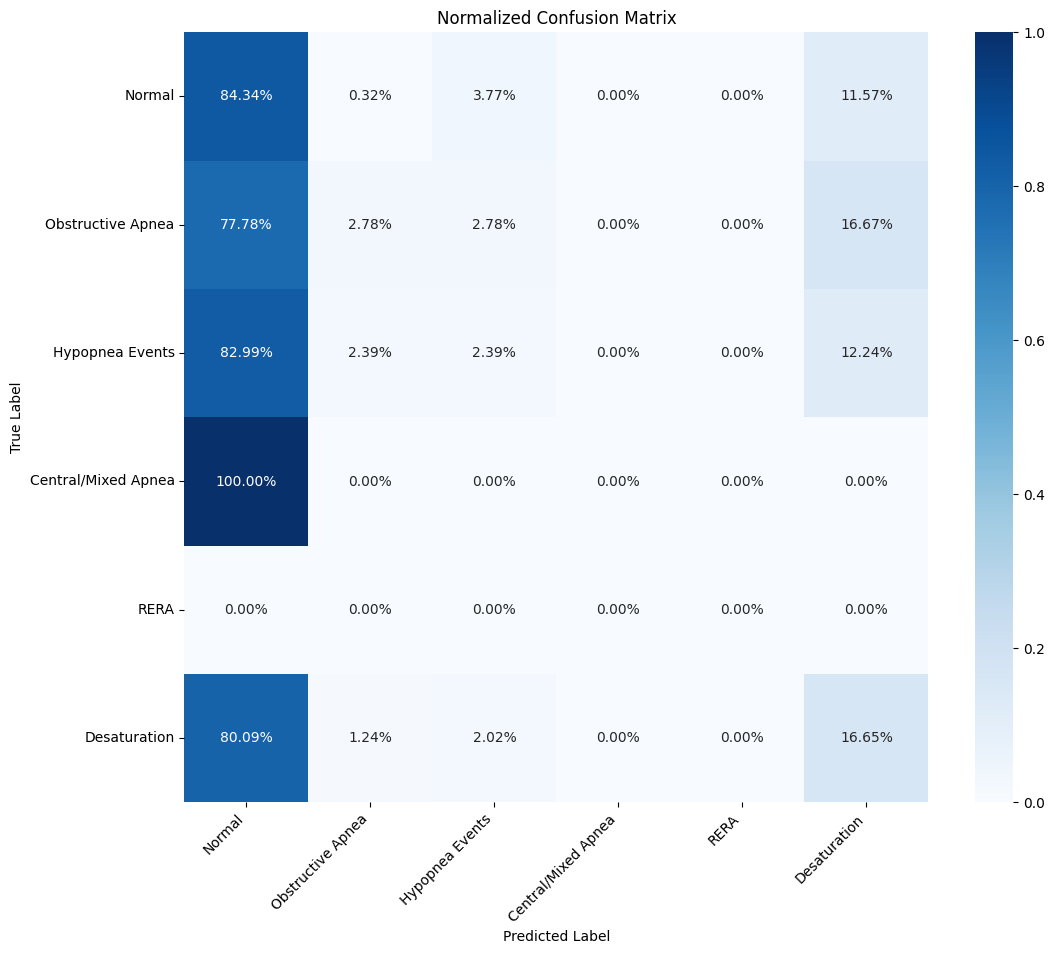

In [12]:
# --- MODIFIED: Evaluation for Multi-Class ---
print("\nEvaluating final model on the test set...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report and Confusion Matrix ---
print('\nClassification Report')
print('---------------------')

### FIX: Add the 'labels' parameter to ensure all 9 classes are reported ###
# N_OUTPUTS was defined earlier as 9
report_labels = range(N_OUTPUTS) 
print(classification_report(
    all_labels, 
    all_preds, 
    labels=report_labels,  # <-- THIS IS THE FIX
    target_names=CLASS_NAMES, 
    zero_division=0
))

print('\nConfusion Matrix')
print('----------------')
# The confusion matrix also benefits from specifying the labels
cm = confusion_matrix(all_labels, all_preds, labels=report_labels)

# Normalize the confusion matrix
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Blues', 
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES
)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha="right")
plt.show()

In [15]:
### MODIFIED: Leave-One-Night-Out for MULTI-CLASS ###
from imblearn.over_sampling import RandomOverSampler # Import fallback sampler

# --- Main LONO Loop ---
all_fold_predictions = []
all_fold_true_labels = []

logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=groups)
print(f"Starting Leave-One-Night-Out cross-validation with {n_folds} folds...\n")
max_grad_norm = 1.0

# --- Loop through each fold ---
for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    
    test_night = np.unique(groups[test_idx])[0]
    print(f"--- FOLD {fold + 1}/{n_folds} (Testing on Night: {test_night}) ---")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- MODIFIED: Balance the TRAINING data for this fold using robust SMOTE ---
    print(f"  - Original training distribution: {Counter(y_train)}")
    nsamples, n_timesteps, n_features = X_train.shape
    X_train_reshaped = X_train.reshape((nsamples, n_timesteps * n_features))
    
    class_counts = Counter(y_train)
    # Check if there are any minority classes to oversample
    minority_classes = {label: count for label, count in class_counts.items() if label != 0}
    
    if not minority_classes:
        print("  - No minority classes in this fold's training data. Skipping resampling.")
        X_train_resampled, y_train_resampled = X_train_reshaped, y_train
    else:
        min_class_count = min(minority_classes.values())
        k = min_class_count - 1

        if k < 1:
            print(f"  - Warning: Smallest minority class has {min_class_count} samples. Using RandomOverSampler.")
            sampler = RandomOverSampler(random_state=RANDOM_STATE)
        else:
            print(f"  - Smallest minority class has {min_class_count} samples. Setting k_neighbors for SMOTE to {k}.")
            sampler = SMOTE(random_state=RANDOM_STATE, k_neighbors=k)
        
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_reshaped, y_train)

    print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")
    X_train_resampled = X_train_resampled.reshape(-1, n_timesteps, n_features)

    # Create PyTorch DataLoaders
    X_train_tensor = torch.from_numpy(X_train_resampled).float()
    y_train_tensor = torch.from_numpy(y_train_resampled).long()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long()
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize a NEW model and other components for this fold
    model = ImprovedCNN(n_features=n_features, n_outputs=N_OUTPUTS, n_timesteps=n_timesteps).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=20, verbose=False, path=f'lono_checkpoint_fold_{fold}.pt')
    
    # Training loop for the current fold...
    for epoch in range(EPOCHS):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"  - Early stopping triggered at epoch {epoch + 1}.")
            break

    print(f"  - Training complete for fold {fold + 1}.")
    
    # Load the BEST model for this fold and evaluate
    model.load_state_dict(torch.load(f'lono_checkpoint_fold_{fold}.pt'))
    model.eval()
    fold_preds = []
    fold_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_preds.extend(predicted.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
    
    all_fold_predictions.extend(fold_preds)
    all_fold_true_labels.extend(fold_labels)
    print(f"  - Evaluation complete for fold {fold + 1}.\n")

# --- FINAL AGGREGATED EVALUATION ---
print("\n====================================================")
print("Leave-One-Night-Out Cross-Validation Complete.")
print("Aggregated Results Across All Folds:")
print("====================================================")

### FIX: Add the 'labels' parameter here as well ###
report_labels = range(N_OUTPUTS)
print(classification_report(
    all_fold_true_labels, 
    all_fold_predictions, 
    labels=report_labels, # <-- THIS IS THE FIX
    target_names=CLASS_NAMES, 
    zero_division=0
))

# The confusion matrix also benefits from specifying the labels
cm = confusion_matrix(all_fold_true_labels, all_fold_predictions, labels=report_labels)
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Blues', 
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES
)
plt.title('Aggregated Normalized Confusion Matrix (LONO)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha="right")
plt.show()

Starting Leave-One-Night-Out cross-validation with 9 folds...

--- FOLD 1/9 (Testing on Night: 04-04-2025) ---
  - Original training distribution: Counter({np.int64(0): 25018, np.int64(5): 2183, np.int64(2): 1000, np.int64(1): 135, np.int64(3): 6, np.int64(4): 4})
  - Smallest minority class has 4 samples. Setting k_neighbors for SMOTE to 3.
  - Resampled training distribution: Counter({np.int64(0): 25018, np.int64(2): 25018, np.int64(5): 25018, np.int64(1): 25018, np.int64(3): 25018, np.int64(4): 25018})


KeyboardInterrupt: 